<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/210117_%EB%B2%94%EC%A3%BC%ED%98%95_%EB%B0%8F_TVT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 범주형 데이터의 분석과 데이터의 분할

수치형 데이터 이외에 범주형 데이터를 다루는 방법에 대해 확인하려고 한다. 이와 함께 데이터의 전처리 이후 테스트 데이터와 검증용 데이터를 나누는 이유 및 그 방법을 확인하고자 한다.

## 1. 범주형 데이터

범주형 데이터는, 수치형 데이터와는 다르게 종류를 표시하는 데이터를 말한다. 대표적인 예시는 다음과 같다.

- 성별 : 남자, 여자
- 등급 : A, B, C...
- 혈액형 : A, B, O, AB

이러한 범주형 데이터를 보면 또 두 가지로 나눌 수 있음을 알 수 있다.
- 순서가 있는 특성 : 정렬을 통해 진행
- 순서가 없는 특성 : 구분만 한다.

예시 데이터를 통해 이를 구분하고 전처리를 진행하고자 한다.

In [ ]:
import pandas as pd
df = pd.DataFrame([
                   ['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']
])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


보다시피, color의 경우는 순서가 없는 특성이나, size의 경우는 순서를 정할 수 있는 특성이다. 이 두가지에 따라 다른 전처리를 진행하려고 한다.

## 2. 범주형 데이터의 전처리

먼저 순서형 데이터의 전처리를 진행하고자 한다.
순서 특성을 올바르게 주기 위해서는 범주형 문자열 값을 정수로 바꿔주어야 한다. 이미 정수로서 그 역할을 할 경우는 문제가 없겠으나, 그것이 아닐 경우에는 매핑함수를 직접 만들어야 한다.

위의 예시의 경우에는 M, L, XL 만으로는 산술적 차이를 확인하기 어렵기에 직접 매핑함수를 만들려고 한다.

In [ ]:
size_mapping = {
    'XL':3,
    'L':2,
    'M':1
}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


한편, class label을 실수가 아닌 정수로 변환하는 것이 좋으므로
*(정확히는 좋다고 합니다. by 참조도서)*

label값들을 정수로 변환하는 것이 중요하다.

In [4]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

## 2. One-Hot Encoding / Dummy 변수

허나, color를 똑같은 방식대로 하려자니 컬러 값에는 순서가 없으나 같은 방식으로 0, 1, 2를 하자니 모델에서 이 숫자가 의미있는 결과를 만들지도 모른다.

이 문제를 해결하는 방법 중 하나는 **One-Hot Encoding**이라는 방법이다. 순서 없는 특성에 들어있는 고유의 값 마다 새로운 더미 특성을 부여한다.

위의 예에서 blue의 경우는
- blue = 1, red = 0, green = 0

이렇게 진행한다.


In [8]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:,0] = color_le.fit_transform(X[:,0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=np.int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
oh_enc = OneHotEncoder(categories='auto')
col_trans = ColumnTransformer([('oh_enc', oh_enc, [0])], remainder='passthrough')
col_trans.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

혹은 Pandas의 get_dummies를 활용할 수 있다.
일반적인 dataframe에 적용가능하다.


In [17]:
#prefix를 붙여야, 색을 적용한다.
pd.get_dummies(df.loc[:,'color'], prefix = 'color')

,color_blue,color_green,color_red
0,0,1,0
1,0,0,1
2,1,0,0


## 3. 다중 공산성(multicollinearity) 문제

one-hot encoding된 data-set을 사용할 때에는, 다중 공산성 문제가 발생할 수 있다. 특성 간의 상관 관계가 높으면 역행렬 계산이 어려워 질 수 있다.

좀 더 구체적으로, 다중 공산성(multicollinearity)란 독립 변수의 일부가 다른 독립 변수의 조합으로 표현될 수 있음을 뜻한다. 이는 독립 변수들이 서로 독립이 아니라 상관관계가 강한 경우에 발생한다.

위에서 역행렬의 계산이 어려워 질 수 있다고 언급했는데, 선형종속 관계가 발생하는 경우 **행렬이 full-rank가 아니게 되어 역행렬이 존재하지 않는 현상이 발생하게 된다.**

One-hot Encoding에서는, 이를 막기 위해.특성 열 하나를 삭제한다.
위의 예시에서는 color_blue를 삭제헤도 크게 문제가 없는데 color_red와 color_green이 모두 0일 경우, blue임을 알 수 있기 때문이다.

In [24]:
pd.get_dummies(df[['price', 'color', 'size']],
               drop_first=True)

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


한편으로, 이를 함수화 시켜 한번에 처리할 수도 있다.

In [ ]:
def make_dummy(df, col_list):

  return_df = pd.DataFrame(index = df.index)

  for col in col_list:
    temp_df = pd.get_dummies(df.loc[:,col], prefix = col)
    final_col = temp_df.columns[-1]
    temp_df.drop(final_col, axis=1, inplace=True)
    return_df = pd.concat([return_df, temp_df], axis = 1)

  return return_df

## 4. 과적합이란?  데이터 셋의 분류

학습시 가장 중요한 점은 훈련 셋과 테스트 셋을 분류해야 한다는 점이다. 
편항되지 않는 성향 측정을 위해서는 훈련 셋에서 사용하지 않은 데이터로 테스트를 진행해야 한다.

- Train Set : 모델을 학습하는 데에만 쓰인다.
- Validation Set : 학습된 모델의 성능을 평가, 과적합을 검토하는 데에도 쓰인다.
- Test Set : 최종 성능을 평가하는데에 쓰인다.

Validation Set과 Test Set이 비슷해 보이는데, 굳이 Validation Set을 쓰는 이유를 보고자 한다.

Training Set만을 사용하여 '과도하게' 학습 시킬 경우, 새로운 데이터가 들어올 경우 설명에 대한 정확도가 떨어지는 현상이 발생하는데, 이를 **'과적합'** 이라고 한다.


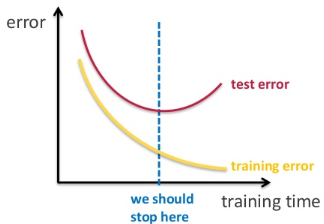


"We should Stop Here"이라고 표시된 부분, 저 지점을 찾기 위해 Validation set을 활용하면 된다.
보통은 Train : Validation : Test = 6 : 2 : 2로 나누면 좋다고 하더라(?)

아무튼 실제 데이터를 통해 이것을 나누는 예시를 보려고 한다.

In [18]:
import seaborn as sns

tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [ ]:
from sklearn.model_selection import train_test_split

# 우선 나눌 input array x 와 output array y 를 정의합니다

x = tips.drop('total_bill',axis=1)
y = tips['total_bill']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size = 0.8) 
# 20%만 잘라서 test 로 만듭니다.
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, train_size = 0.75)
# 그 후 전체의 20%가 또 되게 하려면? 0.75를 Train으로 줍니다.

위와 같이 할 경우 전체 데이터 셋의 20%가 테스트 셋에 배당 후,
남은 80%의 25% 즉 20%가 유효성 검사 셋에 배당된다.

한편, 패키지를 사용하지 않고 이를 직접 코딩할 수도 있다.

In [ ]:
# index number를 random하게 할당하는 방식.
def tvt_split(df, y_col, weight = [6, 2, 2]):

  df_x = df.drop(y_col, axis = 1)
  df_y = df.loc[:,[y_col]]

  data_size = df.shape[0]
  index = random.sample(range(data_size), data_size)

  train_idx = int(data_size * weight[0] / np.sum(weight))
  train_idx_list = index[:train_idx]

  val_idx = train_idx + int(data_size * weight[1] / np.sum(weight))
  val_idx_list = index[train_idx:val_idx]

  test_idx_list = index[val_idx:]

  return_dict = {'train_x': df_x.loc[train_idx_list,:],
                 'train_y': df_y.loc[train_idx_list,:],
                 'val_x': df_x.loc[val_idx_list,:],
                 'val_y': df_y.loc[val_idx_list,:],
                 'test_x': df_x.loc[test_idx_list,:],
                 'test_y': df_y.loc[test_idx_list,:]}

  return return_dict